<a href="https://colab.research.google.com/github/indianspeedster/edu-ml/blob/main/outputs/classifier_notebook_augmented(w2v)_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install transformers

In [7]:
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install nltk
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 25.6 MB/s eta 0:00:00


In [17]:
!pip install numpy==1.22.4


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


In [ ]:
import os
os.kill(os.getpid(), 9)

### Import relevent libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import io
import json
import os
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import requests
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, AdamWeightDecay, get_linear_schedule_with_warmup

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from statistics import median
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import gensim
import gensim.downloader
seed = 1331
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/cc/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cc/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
device=torch.device('cuda:0')
torch.cuda.get_device_name(0)

'Quadro RTX 6000'

### Fetch and store the data

In [ ]:
_HEADER = ["text", "category"]
PATTERNS = {
    "train": "https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data"
             "/master/CrossValidation/autoGeneFromRealAnno/autoGene_2018_03_"
             "22-13_01_25_169/CrossValidation/KFold_1/trainset/{f}",
    "test": "https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data/"
            "master/CrossValidation/autoGeneFromRealAnno/autoGene_2018_03_"
            "22-13_01_25_169/CrossValidation/KFold_1/testset/csv/{f}"
}

LIST_OF_FILES = (
    'alarm_query.csv\nalarm_remove.csv\nalarm_set.csv\naudio_volum'
    'e_down.csv\naudio_volume_mute.csv\naudio_volume_up.csv\ncalend'
    'ar_query.csv\t\ncalendar_remove.csv\t\ncalendar_set.csv\t\ncoo'
    'king_recipe.csv\t\ndatetime_convert.csv\t\ndatetime_query.csv'
    '\t\nemail_addcontact.csv\t\nemail_query.csv\t\nemail_querycon'
    'tact.csv\t\nemail_sendemail.csv\t\ngeneral_affirm.csv\t\ngener'
    'al_commandstop.csv\t\ngeneral_confirm.csv\t\ngeneral_dontcare.'
    'csv\t\ngeneral_explain.csv\t\ngeneral_joke.csv\t\ngeneral_neg'
    'ate.csv\t\ngeneral_praise.csv\t\ngeneral_quirky.csv\t\ngenera'
    'l_repeat.csv\t\niot_cleaning.csv\t\niot_coffee.csv\t\niot_hue'
    '_lightchange.csv\t\niot_hue_lightdim.csv\t\niot_hue_lightoff.'
    'csv\t\niot_hue_lighton.csv\t\niot_hue_lightup.csv\t\niot_wemo_'
    'off.csv\t\niot_wemo_on.csv\t\nlists_createoradd.csv\t\nlists_'
    'query.csv\t\nlists_remove.csv\t\nmusic_likeness.csv\t\nmusic_q'
    'uery.csv\t\nmusic_settings.csv\t\nnews_query.csv\t\nplay_audio'
    'book.csv\t\nplay_game.csv\t\nplay_music.csv\t\nplay_podcasts.'
    'csv\t\nplay_radio.csv\t\nqa_currency.csv\t\nqa_definition.csv'
    '\t\nqa_factoid.csv\t\nqa_maths.csv\t\nqa_stock.csv\t\nrecomme'
    'ndation_events.csv\t\nrecommendation_locations.csv\t\nrecomme'
    'ndation_movies.csv\t\nsocial_post.csv\t\nsocial_query.csv\t\n'
    'takeaway_order.csv\t\ntakeaway_query.csv\t\ntransport_query.c'
    'sv\t\ntransport_taxi.csv\t\ntransport_ticket.csv\t\ntransport'
    '_traffic.csv\t\nweather_query.csv\t'.split())




def _get_category_rows(fname: str, set_name: str):
    pattern = PATTERNS[set_name]
    url = pattern.format(f=fname)
    request = requests.get(url)

    reader = csv.reader(
        io.StringIO(request.content.decode("utf-8")), delimiter=";"
    )
    first_row = next(reader)
    scenario_i, intent_i = first_row.index("scenario"), first_row.index(
        "intent")
    answer_i = first_row.index("answer_from_anno")

    rows = []
    for row in reader:
        text = row[answer_i]
        category = f"{row[scenario_i]}_{row[intent_i]}"
        rows.append([text, category])
    return rows


def _get_final_rows(set_name: str):
    final_rows = [_HEADER]
    for f in tqdm(LIST_OF_FILES):
        final_rows += _get_category_rows(f, set_name)
    return final_rows


def _write_data_into_file(path, rows):
    with open(path, "w") as data_file:
        writer = csv.writer(data_file, quoting=csv.QUOTE_ALL)
        writer.writerows(rows)


def _main():
    data_dir = os.getcwd()

    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    print("Getting train data")
    train_rows = _get_final_rows(set_name="train")
    _write_data_into_file(
        path=os.path.join(data_dir, "train.csv"),
        rows=train_rows
    )

    print("Getting test data")
    test_rows = _get_final_rows(set_name="test")
    _write_data_into_file(
        path=os.path.join(data_dir, "test.csv"),
        rows=test_rows
    )

    print("Creating categories.json file")
    _, train_cats = zip(*train_rows[1:])
    _, test_cats = zip(*test_rows[1:])
    categories = sorted(list(
        set(train_cats) | set(test_cats)
    ))
    with open(os.path.join(data_dir, "categories.json"), "w") as f:
        json.dump(categories, f)


if __name__ == "__main__":
    _main()


Getting train data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:09<00:00,  6.74it/s]


Getting test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:08<00:00,  7.34it/s]

Creating categories.json file


### Load and visualize data

In [55]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.columns = ["speech_text","intent"]
test_data.columns = ["speech_text","intent"]

In [4]:
train_data.describe()

,speech_text,intent
count,9960,9960
unique,9960,64
top,what alarms do i have set right now,alarm_query
freq,1,175


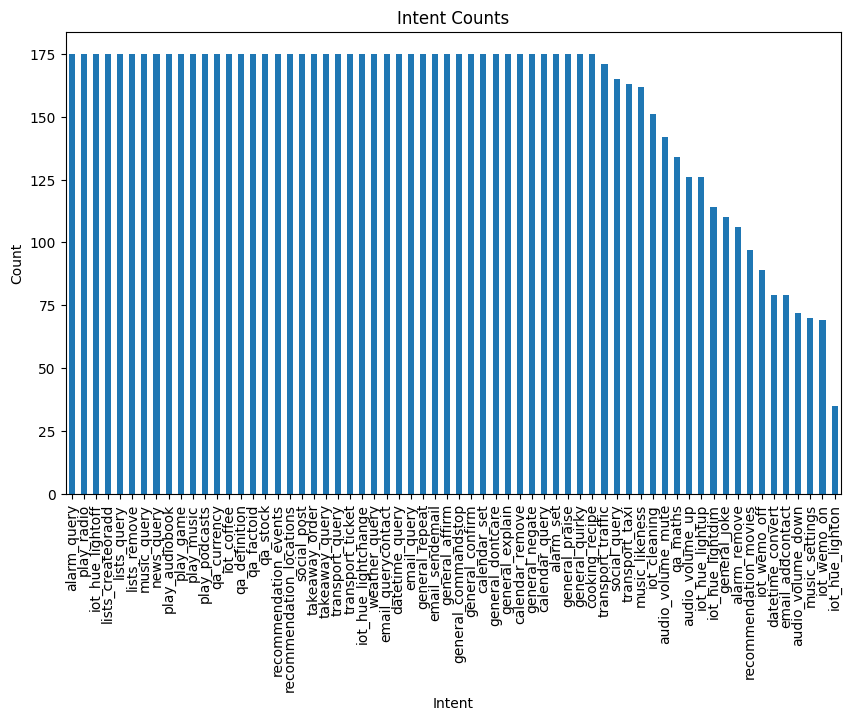

In [5]:
intent_counts = train_data['intent'].value_counts()
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar')
plt.title('Intent Counts')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()

## Data Augmentation


In [6]:
#model_gn = gensim.downloader.load('word2vec-google-news-300')
model_gn = gensim.models.KeyedVectors.load_word2vec_format("/home/cc/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz", binary=True)


### function to implement the augmentation strategy

In [13]:
stop_words = set(stopwords.words('english'))

In [7]:
def get_pos_tags(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    return pos_tags

In [32]:
def augmentation(sentence, threshold = 0.60):
  pos_tag = get_pos_tags(sentence)
  sentence = sentence.split(" ")
  ans = []
  for i in sentence:
    if i.lower() in stop_words:
      ans.append(i)
      continue
    else:
      try:
        word = model_gn.most_similar(i, topn=2)[0]
        if word[1]>= threshold:
          ans.append(word[0])
        else:
          ans.append(i)
      except KeyError:
        ans.append(i)
  pos_tag_1 = get_pos_tags(" ".join(ans))
  for i in range(len(sentence)):
    if pos_tag[i][1] == pos_tag_1[i][1] :
      sentence[i] = pos_tag_1[i][0]
  return " ".join(sentence)

In [33]:
augmented_data = train_data.copy()
augmented_data["speech_text"] = augmented_data["speech_text"].apply(augmentation, threshold=0.60)

In [34]:
augmented_data.to_csv("augmented_data.csv")

In [56]:
train_data = pd.concat([train_data, augmented_data], axis=0)

### Plotting value counts post data augmentation

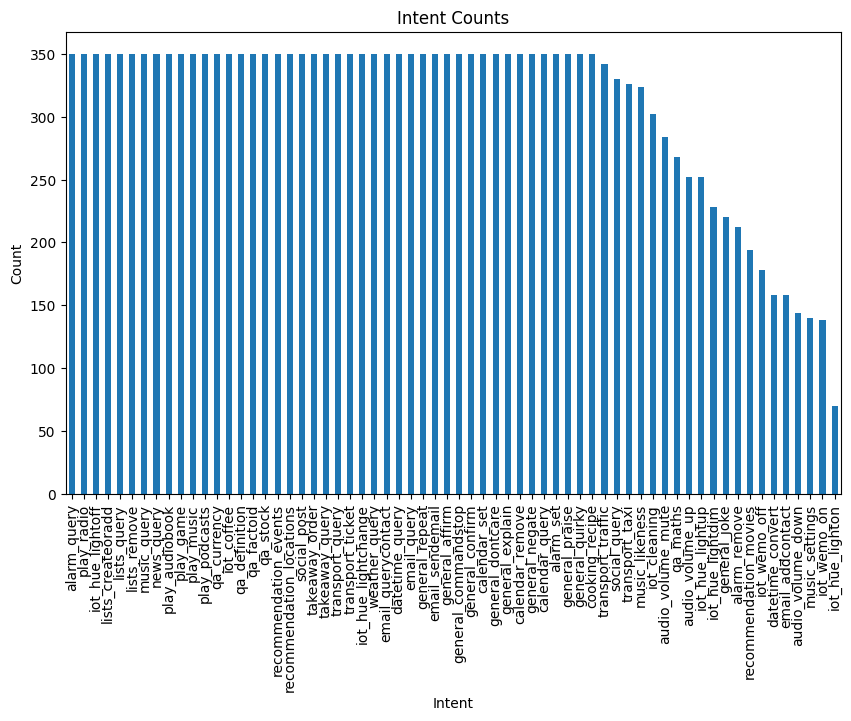

In [57]:
intent_counts = train_data['intent'].value_counts()
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar')
plt.title('Intent Counts')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()

#### Splitting the data into train and validation

In [58]:
df_train,df_val=train_test_split(train_data,test_size=0.10 ,random_state=seed, shuffle=True)

In [59]:
unique_labels = df_train['intent'].unique()
sampled_df = pd.DataFrame()
for label in unique_labels:
    label_df = df_train[df_train['intent'] == label]
    samples = label_df.sample(n=60, random_state=seed)
    sampled_df = sampled_df.append(samples)
sampled_df.reset_index(drop=True, inplace=True)

### Creating different dataset of 10 samples each with different data points.

In [60]:
df = sampled_df
df['sampled'] = False

label_counts = df['intent'].value_counts()

max_count = label_counts.max()
min_count = label_counts.min()

num_datasets = max_count // 10

training_datasets = []

for i in range(num_datasets):
    dataset = pd.DataFrame()
    for label in df['intent'].unique():
        label_df = df[(df['intent'] == label) & (df['sampled'] == False)]
        if len(label_df) >= 10:
            samples = label_df.sample(n=10)
            df.loc[samples.index, 'sampled'] = True
            dataset = pd.concat([dataset, samples])
        else:
            samples = label_df
            df.loc[samples.index, 'sampled'] = True
            dataset = pd.concat([dataset, samples])
    training_datasets.append(dataset)


In [61]:
val_data = df_val

### Encode the labels

In [62]:
le=LabelEncoder()
for train_data in training_datasets:
  train_data['intent']=le.fit_transform(train_data['intent'])
val_data['intent']=le.fit_transform(val_data['intent'])
test_data['intent']=le.transform(test_data['intent'])

In [63]:
print(le.classes_)

['alarm_query' 'alarm_remove' 'alarm_set' 'audio_volume_down'
 'audio_volume_mute' 'audio_volume_up' 'calendar_query' 'calendar_remove'
 'calendar_set' 'cooking_recipe' 'datetime_convert' 'datetime_query'
 'email_addcontact' 'email_query' 'email_querycontact' 'email_sendemail'
 'general_affirm' 'general_commandstop' 'general_confirm'
 'general_dontcare' 'general_explain' 'general_joke' 'general_negate'
 'general_praise' 'general_quirky' 'general_repeat' 'iot_cleaning'
 'iot_coffee' 'iot_hue_lightchange' 'iot_hue_lightdim' 'iot_hue_lightoff'
 'iot_hue_lighton' 'iot_hue_lightup' 'iot_wemo_off' 'iot_wemo_on'
 'lists_createoradd' 'lists_query' 'lists_remove' 'music_likeness'
 'music_query' 'music_settings' 'news_query' 'play_audiobook' 'play_game'
 'play_music' 'play_podcasts' 'play_radio' 'qa_currency' 'qa_definition'
 'qa_factoid' 'qa_maths' 'qa_stock' 'recommendation_events'
 'recommendation_locations' 'recommendation_movies' 'social_post'
 'social_query' 'takeaway_order' 'takeaway_quer

### Setting up BERT Tokenizer

In [64]:
from transformers import AutoTokenizer, TrainingArguments, Trainer

In [65]:
pre_trained_BERTmodel='bert-large-uncased'
BERT_tokenizer=AutoTokenizer.from_pretrained(pre_trained_BERTmodel)

In [66]:
import datasets
def tokenize_data(example):
    encoded_input = BERT_tokenizer(example["speech_text"], padding="max_length", truncation=True)
    return {"input_ids": encoded_input["input_ids"], "attention_mask": encoded_input["attention_mask"], "labels": example["intent"]}

In [67]:
train_dataset=[]
for train_data_ in training_datasets:
  traindataset = datasets.Dataset.from_pandas(train_data_)
  train_dataset.append(traindataset.map(tokenize_data))

In [68]:
testdataset = datasets.Dataset.from_pandas(test_data)
test_dataset = testdataset.map(tokenize_data)

In [69]:
valdataset = datasets.Dataset.from_pandas(val_data)
eval_dataset = valdataset.map(tokenize_data)

In [70]:
test_dataset

Dataset({
    features: ['speech_text', 'intent', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1076
})

In [71]:
train_dataset

[Dataset({
     features: ['speech_text', 'intent', 'sampled', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 640
 }),
 Dataset({
     features: ['speech_text', 'intent', 'sampled', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 640
 }),
 Dataset({
     features: ['speech_text', 'intent', 'sampled', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 640
 }),
 Dataset({
     features: ['speech_text', 'intent', 'sampled', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 640
 }),
 Dataset({
     features: ['speech_text', 'intent', 'sampled', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 640
 }),
 Dataset({
     features: ['speech_text', 'intent', 'sampled', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 640
 })]

In [72]:
args = TrainingArguments(
        output_dir="./output",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8 ,
        per_device_eval_batch_size=8 ,
        num_train_epochs=20,
        warmup_ratio= 0.1,
        weight_decay= 0.001,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=1,
            )

In [73]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    AutoConfig,
    BertModel,
)

import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput


class BertModelWithCustomLossFunction(nn.Module):
    def __init__(self):
        super(BertModelWithCustomLossFunction, self).__init__()
        self.num_labels = len(df_train["intent"].unique())
        self.bert = BertModel.from_pretrained(
            pre_trained_BERTmodel, num_labels=self.num_labels
        )
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(1024, self.num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        output = self.dropout(outputs.pooler_output)
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            # you can define any loss function here yourself
            # see https://pytorch.org/docs/stable/nn.html#loss-functions for an overview
            loss_fct = nn.CrossEntropyLoss()
            # next, compute the loss based on logits + ground-truth labels
            loss = loss_fct(logits.view(-1, self.num_labels), labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [74]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
best_accuracy = 0
i = 1
for train_dat in train_dataset:
  BERT_model = BertModelWithCustomLossFunction()
  trainer = Trainer(
        model = BERT_model,
        args = args,
        train_dataset=train_dat,
        eval_dataset=eval_dataset,
        tokenizer=BERT_tokenizer,
        compute_metrics=compute_metrics,)
  trainer.train()
  evaluation_metrics = trainer.predict(test_dataset)
  accuracy = evaluation_metrics.metrics['test_accuracy']
  test_data[f"prediction_{i}"] = [np.argmax(evaluation_metrics.predictions[i]) for i in range(len(evaluation_metrics.predictions))]
  test_data.to_csv(f"prediction_on_non_augmented_{i}.csv")
  best_accuracy = max(accuracy, best_accuracy)
  print(f"Best Test Accuracy for this training dataset: {accuracy}")
  torch.cuda.empty_cache()
  i += 1

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/cc/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyT

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.114191,0.048695,0.023689,0.048695,0.022492
2,No log,3.806388,0.130020,0.188506,0.130020,0.097526
3,No log,3.153686,0.377510,0.440742,0.377510,0.333676
4,No log,2.361499,0.546687,0.581800,0.546687,0.511517
5,No log,1.682758,0.679217,0.712171,0.679217,0.665006
6,No log,1.332668,0.731928,0.751186,0.731928,0.717181
7,2.902100,1.000320,0.776104,0.786392,0.776104,0.770456
8,2.902100,0.855574,0.797691,0.808898,0.797691,0.796137
9,2.902100,0.813430,0.798193,0.814834,0.798193,0.795941
10,2.902100,0.792398,0.797189,0.808103,0.797189,0.794738


/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/

Best Test Accuracy for this training dataset: 0.8401486988847584


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/cc/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyT

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.105210,0.031124,0.021853,0.031124,0.016405
2,No log,3.931891,0.087349,0.214102,0.087349,0.076655
3,No log,3.105507,0.477410,0.539545,0.477410,0.450125
4,No log,2.440660,0.597892,0.657233,0.597892,0.579497
5,No log,1.827868,0.671185,0.711946,0.671185,0.649696
6,No log,1.497696,0.697289,0.717092,0.697289,0.679781
7,2.885400,1.233049,0.733936,0.754082,0.733936,0.728082
8,2.885400,0.989030,0.772088,0.781493,0.772088,0.768800
9,2.885400,0.922445,0.776104,0.790970,0.776104,0.773081
10,2.885400,0.819396,0.800703,0.808674,0.800703,0.796482


/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/

Best Test Accuracy for this training dataset: 0.8522304832713755


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/cc/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyT

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.113783,0.025602,0.014693,0.025602,0.011815
2,No log,3.640521,0.218373,0.269473,0.218373,0.188504
3,No log,2.728708,0.592871,0.647055,0.592871,0.567653
4,No log,1.981624,0.683735,0.703614,0.683735,0.662853
5,No log,1.403901,0.754518,0.781996,0.754518,0.741255
6,No log,1.079844,0.780120,0.791866,0.780120,0.766824
7,2.556100,0.898037,0.796185,0.809735,0.796185,0.794854
8,2.556100,0.816851,0.801707,0.816899,0.801707,0.799256
9,2.556100,0.793327,0.805221,0.818056,0.805221,0.803217
10,2.556100,0.789856,0.808735,0.823697,0.808735,0.807636


/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/

Best Test Accuracy for this training dataset: 0.837360594795539


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/cc/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyT

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.115595,0.028112,0.012068,0.028112,0.010802
2,No log,4.038762,0.052209,0.068724,0.052209,0.030965
3,No log,3.386777,0.338855,0.428587,0.338855,0.304804
4,No log,2.366557,0.602912,0.665201,0.602912,0.568232
5,No log,1.638518,0.721386,0.757658,0.721386,0.701226
6,No log,1.188877,0.792169,0.797893,0.792169,0.787244
7,2.919000,0.933928,0.801205,0.817263,0.801205,0.795691
8,2.919000,0.829112,0.813755,0.824542,0.813755,0.812633
9,2.919000,0.754853,0.817269,0.830454,0.817269,0.816096
10,2.919000,0.729292,0.828815,0.836013,0.828815,0.828846


/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/

Best Test Accuracy for this training dataset: 0.8382899628252788


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/cc/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyT

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.068842,0.044177,0.039663,0.044177,0.016668
2,No log,3.616140,0.205321,0.305798,0.205321,0.176310
3,No log,2.788473,0.564257,0.656512,0.564257,0.534578
4,No log,1.956667,0.706325,0.747265,0.706325,0.693427


/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
best_accuracy

0.8531598513011153

In [ ]:
accuracy_list = [0.8252788104089219, 0.8531598513011153,  0.8299256505576208, 0.8355018587360595, 0.8475836431226765, 0.8420074349442379]

In [ ]:
import statistics
statistics.stdev(accuracy_list)

0.01063980958985297

In [ ]:
statistics.mean(accuracy_list)

0.838909541511772

In [ ]:
df_n = pd.read_csv("prediction_on_non_augmented6.csv")

In [ ]:
df_n.head()

,Unnamed: 0,speech_text,intent,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6
0,0,tell me time of alarm you set,0,0,0,0,0,0,0
1,1,list all of my alarms,0,0,0,0,0,0,0
2,2,alarm settings,0,0,0,2,2,1,2
3,3,what alarms are set for today,0,0,0,0,0,0,0
4,4,please see see for me the alarms that you have...,0,0,0,0,0,0,0
